<a href="https://colab.research.google.com/github/federicasibilla/GenAI_ecology/blob/main/code/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Initial steps:

1.   Copy this notebook to your google Colab account (*File --> Save a Copy in Drive*)
2.   Go to your drive and open the copied file, located in your *Colab Notebooks* folder

##Working with Collab Notebooks:

1.   Click inside a cell with code and press SHIFT+ENTER (or click "PLAY" button) to execute it.
2.   Re-executing a cell will reset it (any input will be lost).
3.   Execute cells TOP TO BOTTOM.
4.  Use TAB for [code autocompletion and function parameters hint](https://colab.research.google.com/notebooks/basic_features_overview.ipynb#scrollTo=d4L9TOP9QSHn)
5. Notebooks are saved to your Google Drive (make sure to click on "COPY TO DRIVE" when opening a notebook shared with you).
6. Mount your Google Drive to have a direct access from a notebook to the files stored in the drive (this includes Team Drives).
7. If using Colab's virtual storage only, all the uploaded/stored files will get deleted when a runtime is recycled.

Mount Google Drive to Save results. This will be needed for each of the notebooks.


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Set directory to store results. Directory **AI4Ecology** is located at the root directory of your drive. It is used by all notebooks.

In [2]:
google_drive_dir = "/content/gdrive/My Drive/AI4Ecology/"

In [3]:
import os
dir_name = google_drive_dir+'saved_reals'
if not os.path.exists(dir_name) :
  print(color.RED+"ERROR: "+color.END+" Please run "+color.BOLD+"Pre-processing.ipynb"+" before running this notebook")


# Imports

Import needed libraries


In [5]:
import keras
from keras.models import Model,Sequential, load_model
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,UpSampling2D,BatchNormalization,Lambda,Activation,Input,Flatten,Reshape,Conv2DTranspose
import keras.backend as K
import keras.layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } div.cell.selected {border-left-width: 1px !important;}</style>"))
from PIL import Image
from time import time
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import gc
import psutil
import multiprocessing as mp
import copy
mp.cpu_count()

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split
import os
import glob
from time import time,asctime
from random import randint as r
import random

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import itertools as it

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


#Pre-requisites

This notebooks needs to read patch DB in the right format as explained in notebook Pre-processing.


# Notebook Output

This notebook trains a Variational Auto-Encoder (VAE) using input data from *Pre-processing* notebook. Saves files including fake patches which are the output of the training of VAE.


# Processing

Define variables *n_vars* (species to use) and *incl_soil* (if soil is included in the training). Variables need to be consistent among notebooks.

In [6]:
# set the number of plant species or other similar variables to consider
n_vars=8
# set boolean to include soil type (whether gypsum or not) to be considered as another variable treated as a plant species
incl_soil = True
# (this could be generalized to location i.e. ravine/not, north_face/not, etc... alongside the present of a plant

In [7]:
# Only black and white
n_colors=1

# our GAN is set to handle square images, but we will simply repeat a line of entries multiple times
n_tile=n_vars

dir_name = google_drive_dir+'saved_reals'
if os.path.exists(dir_name):
  file_name =os.path.join(dir_name,'X__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'.parquet.gzip')
  X=pd.read_parquet(file_name)
  n_patches = X.shape[0]
  var_names = X.columns.tolist()

# transform the data into a 4D array of n_patches * n_vars * n_tile * n_colors
X_array=np.array(X)
X_4d=np.tile(X_array,(n_tile,1,1))
X_4d=X_4d.transpose(1,2,0)
X_4d=X_4d[:,np.newaxis].transpose(0,2,3,1)
if n_colors==3:
    X_4d=X_4d*[1,1,1]

X_4d.shape


(2581, 8, 8, 1)

In [8]:
n_patches=X_4d.shape[0]
reals=X_4d[:,:,0,0]

dir_name=google_drive_dir+'saved_arrays'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

file_name='real_patches__'+str(n_vars)+'-vars__'+str(X.shape[0])+'-non_zero_patches.npy'
np.save(os.path.join(dir_name,file_name),reals)

train_y = X_4d
Y_data = train_y
del train_y
Z_data = copy.deepcopy(Y_data)
print('{:.2f}% accuracy would be achieved on this set by simply predicting the complete absence of any species.'.format(100*(1-np.sum(Y_data)/Y_data.size)))

62.15% accuracy would be achieved on this set by simply predicting the complete absence of any species.


#Train Variational Auto-Encoder

Variational Auto-Endoders are a kind of deep generative models (together with GAN). VAE is an autoencoder whose encodings distribution is regularised during the training. This regularisation ensures that the latent space has good properties, in this way it is possible to generate new data. The implementation of a VAE implies an **encoder** and a **decoder**.

* The encoder learns to generate a distribution depending on input samples X from which we can sample a latent variable that is highly likely to generate X samples. Codifies input variables in this latent space.

* The decoder does the complementary operation. It learns to generate an output which is similar to the real data distribution using the latent space.

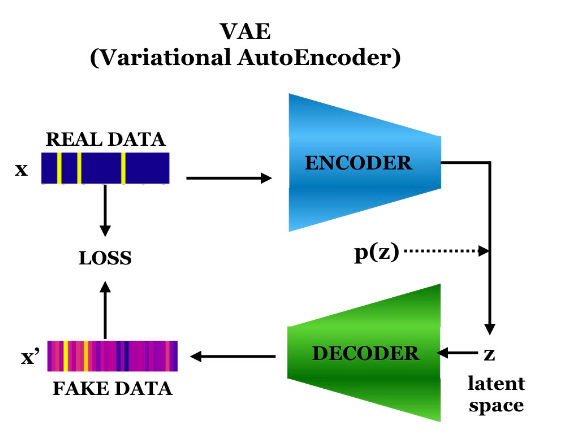

## Building a Variational Auto-Encoder

To be able to run a VAE, the different components have to be implemented, namely:

*   Inputs shapes
*   Build Encoder
*   Build Decoder

once we have the different parts we can create our VAE model. Parameters of the architecture for **decoder** and **encoder** are hardcoded in the functions.

In [9]:
beta = 1

def sampler(layers):
  std_norm = K.random_normal(shape=(K.shape(layers[0])[0], 128), mean=0, stddev=1)
  return layers[0] + layers[1]*std_norm

# Define LOSS for the model
def vae_loss(input_img, output):

	# compute the average MSE error, then scale it up, ie. simply sum on all axes
  x = K.square(output-input_img)
  reconstruction_loss = K.sum(x)

  # compute the KL loss
  kl_loss = - 0.5 * K.sum(1 + sd_layer - K.square(mean_layer) - K.square(K.exp(sd_layer)), axis=-1)

  # return the average loss over all images in batch
  total_loss = K.mean(reconstruction_loss + beta * kl_loss)

  return total_loss

# Define Architecture for the Encoder
def build_encoder(input, stride=2) :

  inp = input
  x = inp
  x = Conv2D(128,(2,2),strides = stride,activation = "relu",padding = "same")(x)
  x = Conv2D(256,(2,2),strides = stride,activation = "relu",padding = "same")(x)
  x = Conv2D(512,(2,2),strides = stride,activation = "relu",padding = "same")(x)
  shape = K.int_shape(x)
  x = Flatten()(x)
  x = Dense(512,activation = "relu")(x)
  x = Dense(256,activation = "relu")(x)
  mean_layer = Dense(128,activation = "relu")(x)
  sd_layer = Dense(128,activation = "relu")(x)
  latent_vector = Lambda(sampler)([mean_layer,sd_layer])

  encoder = Model(inp,latent_vector,name = "VAE_Encoder")

  print("\n"+color.BLUE+"... Encoder ..."+color.END+"\n")
  encoder.summary()

  return encoder, shape, latent_vector, sd_layer, mean_layer

# Define Architecture for the Decoder
def build_decoder(decoder_inp, shape, stride=2) :

  x = decoder_inp
  x = Dense(256,activation = "relu")(x)
  x = Dense(512,activation = "relu")(x)
  x = Dense(shape[1]*shape[2]*shape[3],activation = "relu")(x)
  x = Reshape((shape[1],shape[2],shape[3]))(x)
  x = (Conv2DTranspose(512,(2,2),strides = stride,activation = "relu",padding = "same"))(x)
  x = (Conv2DTranspose(256,(2,2),strides = stride,activation = "relu",padding = "same"))(x)
  x = (Conv2DTranspose(128,(2,2),strides = stride,activation = "relu",padding = "same"))(x)
  outputs = Conv2DTranspose(n_colors, (2,2), activation = 'sigmoid', padding = 'same', name = 'decoder_output')(x)

  decoder = Model(decoder_inp,outputs,name = "VAE_Decoder")

  print("\n\n"+color.BLUE+"... Decoder ..."+color.END+"\n")
  decoder.summary()

  return decoder, outputs

# Define VAE
def build_vae(input, decoder, encoder) :


  vae = Model(input,decoder(encoder(input)),name = "Variational_Auto_Encoder")

  opt=keras.optimizers.Adam(learning_rate=0.0001)
  vae.compile(optimizer = opt,loss = vae_loss,metrics = ["accuracy"])

  vae.compile(optimizer = "adam",loss = vae_loss,metrics = ["accuracy"])

  print("\n"+color.BLUE+" .. VAE ..."+color.END+"\n")
  vae.summary()

  return vae

### Now let's build the VAE.

In [10]:
# Definition of inputs
input = Input( shape = (n_vars,n_tile,n_colors) )

decoder_input = Input( shape = (128,) )


# Building Encoder
encoder, encoder_shape, latent_vector, sd_layer, mean_layer = build_encoder(input)

# Building Decoder
decoder, outputs = build_decoder(decoder_input, shape=encoder_shape)

# Building VAE
vae = build_vae(input, decoder, encoder)


... Encoder ...

Model: "VAE_Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 4, 4, 128)            640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 2, 2, 256)            131328    ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 1, 1, 512)            524800    ['conv2d_1[0][0]']            
                                                                      

# Training

In [11]:
# Training paramaters. Parameters have been set for about 10 minutes training which gives about 99% accuracy
n_repeats = 2 # 10
epochs = 10 # 200
batch_size = 64
learning_rate = 0.0001


dir_name=google_drive_dir+'vae_h5/'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

def check_error(rec,reals) :

    midtone=.5
    threshold=.5
    binary_rec = copy.deepcopy(rec)
    binary_rec=(np.sign(binary_rec-threshold)+1)*midtone

    errors=binary_rec-reals
    abs_errors=abs(errors)
    df_abs_errors = pd.DataFrame(abs_errors).T

    return df_abs_errors

In [13]:
# Loop over the number of repeats and epochs
for i in range(n_repeats):

    # Saving path
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filepath = dir_name+"vae.h5"

    # Encoder and Decoder
    encoder = Model(input,latent_vector,name = "VAE_Encoder")
    decoder = Model(decoder_input,outputs,name = "VAE_Decoder")
    vae = Model(input,decoder(encoder(input)),name = "Variational_Auto_Encoder")

    # Optimizer
    opt=keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    vae.compile(optimizer = opt,loss = vae_loss,metrics = ["accuracy"])

    # Callbacks
    checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # Model Fit
    vae.fit(Z_data,Y_data,batch_size = batch_size, epochs = epochs,validation_split = 0.,shuffle=True,callbacks=callbacks_list)
    accurate_pixels=vae.evaluate(Z_data,Z_data)[1]

    # Predict with VAE
    reals=Y_data[:,:,0,0]
    rec=vae.predict(Z_data)[:,:,:,0].mean(axis=2)


    # Evaluate Error
    df_abs_errors = check_error(rec,reals)
    print('\nProportion of patches with a given number of mispredicted species:')


    # Saving Weights
    results=df_abs_errors.sum().value_counts(normalize=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename='VAE__n_vars='+str(n_vars)+'__incl_soil='+str(incl_soil)+'__beta='+str(beta)+'__model_timestamp='+timestamp+'__accurate_patches={:.2f}%__accurate_pixels={:.2f}%'.format(100*results[0],100*accurate_pixels)
    vae.save_weights(os.path.join(google_drive_dir+'vae_models',filename+'.ckpt'))

    #if we want to save the whole model, not just the checkpoint
    vae.save(os.path.join(google_drive_dir+'vae_models',filename+'.h5'))


Train on 2581 samples
Epoch 1/10
2581/2581 [==============================] - ETA: 0s - loss: 992.8137 - accuracy: 0.6180
Epoch 1: accuracy improved from -inf to 0.61795, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2581/2581 [==============================] - 24s 9ms/sample - loss: 992.8137 - accuracy: 0.6180
Epoch 2/10
2581/2581 [==============================] - ETA: 0s - loss: 847.7776 - accuracy: 0.6654
Epoch 2: accuracy improved from 0.61795 to 0.66544, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5
2581/2581 [==============================] - 19s 7ms/sample - loss: 847.7776 - accuracy: 0.6654
Epoch 3/10
2581/2581 [==============================] - ETA: 0s - loss: 575.8027 - accuracy: 0.7908
Epoch 3: accuracy improved from 0.66544 to 0.79083, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5
2581/2581 [==============================] - 19s 7ms/sample - loss: 575.8027 - accuracy: 0.7908
Epoch 4/10
2581/2581 [==============================] - ETA: 0s - loss: 449.1716 - accuracy: 0.8343
Epoch 4: accuracy improved from 0.79083 to 0.83428, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5
2581/2581 [==============================] - 18s 7ms/sampl

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Proportion of patches with a given number of mispredicted species:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Train on 2581 samples
Epoch 1/10
2581/2581 [==============================] - ETA: 0s - loss: 96.4954 - accuracy: 0.9772
Epoch 1: accuracy improved from -inf to 0.97720, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5
2581/2581 [==============================] - 20s 8ms/sample - loss: 96.4954 - accuracy: 0.9772
Epoch 2/10
2581/2581 [==============================] - ETA: 0s - loss: 73.3770 - accuracy: 0.9840
Epoch 2: accuracy improved from 0.97720 to 0.98401, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5
2581/2581 [==============================] - 19s 7ms/sample - loss: 73.3770 - accuracy: 0.9840
Epoch 3/10
2581/2581 [==============================] - ETA: 0s - loss: 58.6586 - accuracy: 0.9894
Epoch 3: accuracy improved from 0.98401 to 0.98941, saving model to /content/gdrive/My Drive/AI4Ecology/vae_h5/vae.h5
2581/2581 [==============================] - 19s 7ms/sample - loss: 58.6586 - accuracy: 0.9894
Epoch 4/10
2581/2581 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Proportion of patches with a given number of mispredicted species:


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load a checkpoint and check results

In [14]:
# Check Saved models
pattern=google_drive_dir+'vae_models/VAE__n_vars='+str(n_vars)+'*.h5'
print(pattern)
list_files=sorted(glob.glob(pattern))
list_files

/content/gdrive/My Drive/AI4Ecology/vae_models/VAE__n_vars=8*.h5


['/content/gdrive/My Drive/AI4Ecology/vae_models/VAE__n_vars=8__incl_soil=True__beta=1__model_timestamp=2024-01-19_10-55-49__accurate_patches=72.80%__accurate_pixels=95.95%.h5',
 '/content/gdrive/My Drive/AI4Ecology/vae_models/VAE__n_vars=8__incl_soil=True__beta=1__model_timestamp=2024-01-19_10-59-31__accurate_patches=92.17%__accurate_pixels=99.02%.h5']

In [15]:
# Load a specific checkpoint (default is last one)
choice=-1
model_name = list_files[choice]
vae.load_weights(model_name)
model_name

'/content/gdrive/My Drive/AI4Ecology/vae_models/VAE__n_vars=8__incl_soil=True__beta=1__model_timestamp=2024-01-19_10-59-31__accurate_patches=92.17%__accurate_pixels=99.02%.h5'

## Check results after training

In [16]:
# Accuracy
accurate_pixels=vae.evaluate(Z_data,Z_data)[1]
accurate_pixels

0.990217

In [17]:
# Predict and compare
reals=Y_data[:,:,0,0]
rec=vae.predict(Z_data)[:,:,:,0].mean(axis=2)

# Evaluate Error
df_abs_errors = check_error(rec,reals)

print('\nProportion of patches with a given number of mispredicted species:')
results=df_abs_errors.sum().value_counts(normalize=True)
display(results)


Proportion of patches with a given number of mispredicted species:


0.0    0.921736
1.0    0.078264
dtype: float64

# Using VAE: Generate new patches

In [18]:
!pip -q install hvplot
!pip -q install holoviews

import hvplot.pandas
import holoviews as hv
from google.colab import files

#sort the columns according to abundance of plant species
if incl_soil == False:
    offset = 0
if incl_soil == True:
    offset = 1

dir_name=google_drive_dir+'htmls/'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.0 MB/s eta 0:00:00


## Generate patches from the original space

In [19]:
# Functions to create result plots

def chk_results(fakes,select):
    temp = pd.DataFrame(fakes)
    temp = pd.DataFrame(temp.value_counts(ascending=False)/temp.shape[0],columns=['frequency']).reset_index()
    temp.insert(0,'seed',var_names[select])
    temp.insert(0,'preponderance',range(1,1+temp.shape[0],1))
    temp.insert(0,'cumulative',np.cumsum(temp['frequency']))
    temp.columns = ['cumulative','preponderance','seed']+var_names + ['frequency']
    return temp

def plots(fakes_from_dist,title):

    dists = (fakes_from_dist.hvplot.heatmap(x='preponderance',xlabel='Most frequent patches generated for each pioneer species',y='seed',C='frequency',xlim=(1,20)).opts(height=height,width=width)
             +fakes_from_dist.hvplot.line(x='preponderance',y='frequency',by='seed',xlim=(1,30),xlabel='Most frequent patches generated for each pioneer species').opts(height=height,width=width,legend_position='top_right')
            +fakes_from_dist.hvplot.line(x='preponderance',y='cumulative',by='seed',xlim=(1,50),xlabel='Most frequent patches generated for each pioneer species',ylabel='cumulative frequency').opts(height=height,width=width,legend_position='bottom_right')
            )

    mean_patches = fakes_from_dist.drop(['cumulative','preponderance','frequency'],axis='columns').groupby('seed').mean().reindex(var_names).T.iloc[offset:,offset:]

    species = (mean_patches.hvplot.heatmap(xlabel='initial pioneer',ylabel='secondary pioneers',title='Secondary pioneers',rot=45).opts(height=height,width=width)

    +mean_patches.iloc[:,offset:].mean(axis=1).hvplot.bar(rot=0,title='Most likely secondary pioneers',invert=True).opts(height=height,width=width)

    +mean_patches.iloc[:,offset:].sum(axis=0).hvplot.bar(title='Average species per patch for each initial pioneer',rot=45).opts(height=height,width=width)
                    )

    return hv.Layout(dists + species).cols(3).opts(shared_axes=False,title=title)

In [20]:
fudge_factor=1
probs=fudge_factor*reals.mean(axis=0)

#generate according to single-species prob
original_seed = np.eye(8)
px.imshow(original_seed)

In [21]:
#we set the scale of the noise to be large enough to generate variety, but no too large that we end up with patches that do not contain the original seed species
sigma=0.3

midtone = .5
threshold = .5

# Number of fakes to generate
n_fakes = 1000

# Saved Html plots
width=500
height=400

# Show additional plots
show_plots = False

fakes_from_input_space = pd.DataFrame()

# Create fakes
for select in range(1,n_vars,1):

    noise_patches= np.abs(sigma*np.random.randn(n_fakes,n_vars))

    one_seed_multiple_noises = original_seed[select]+noise_patches

    noisy_seeds = np.clip(one_seed_multiple_noises,0,1)

    if show_plots :
      px.imshow(noisy_seeds.transpose()).show()

    # Seeds
    seeds=np.tile(noisy_seeds,(n_tile,1,1))
    seeds=seeds.transpose(1,2,0)
    seeds=seeds[:,np.newaxis].transpose(0,2,3,1)#*[1,1,1]
    seeds_2d=seeds[:,:,0,0]

    # Fakes
    fakes = vae.predict(seeds)
    fakes=fakes.mean(axis=2)
    fakes=np.tile(fakes,(n_tile,1,1,1))
    fakes=fakes.transpose(1,2,0,3)#[:,:,:,0]


    cont_3d = fakes.mean(3)
    fakes_3d=midtone*(1+np.sign(cont_3d-threshold))#.astype(np.uint8)

    fakes = fakes_3d[:,:,0]

    if show_plots :
      px.imshow(np.sort(fakes,axis=0).transpose()).show()

    fakes_from_input_space = fakes_from_input_space.append(chk_results(fakes,select))

<ipython-input-21-3f5f95c07526>:52: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-21-3f5f95c07526>:52: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-21-3f5f95c07526>:52: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-21-3f5f95c07526>:52: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-21-3f5f95c07526>:52: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-21-3f5f95c07526>:52: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [22]:
# Create html page with result plots. Saves html in drive and opens a window to view it in browser
from_input=plots(fakes_from_input_space,'Fakes generated from input space')
hv.save(from_input,dir_name+'from_input_space.html')
files.download(dir_name+'from_input_space.html')

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generate patches from the latent space

In [24]:
#we set the scale of the noise to be large enough to generate variety, but no too large that we end up with patches that do not contain the original seed species
sigma = .2

noise_patches= np.zeros((n_fakes,n_vars))

fakes_from_latent = pd.DataFrame()

for select in range(1,n_vars,1):

    one_seed_multiple_noises = original_seed[select]+noise_patches

    noisy_seeds = one_seed_multiple_noises

    if show_plots :
      px.imshow(noisy_seeds.transpose()).show()

    # Seeds
    seeds=np.tile(noisy_seeds,(n_tile,1,1))
    seeds=seeds.transpose(1,2,0)
    seeds=seeds[:,np.newaxis].transpose(0,2,3,1)#*[1,1,1]
    seeds_2d=seeds[:,:,0,0]

    # Fakes
    latents = encoder.predict(seeds)
    latents_df = pd.DataFrame(latents)

    latent_gen=  np.random.normal(latents,sigma,size=(n_fakes, 128))
    gen_from_latent=decoder.predict(latent_gen)

    def fakes_from_gen(array,threshold,edge_fraction):

        n_tile = array.shape[2]
        edge = int(np.floor(edge_fraction * n_tile))
        begin_select = edge
        end_se1ect = n_tile - edge
        cont_fakes=array.mean(3)[:,:,begin_select:end_se1ect].mean(2)

        midtone = 0.5;
        fakes=np.floor(midtone*(1+np.sign(cont_fakes-threshold)))#.astype(np.uint8)
        return fakes

    fakes=fakes_from_gen(gen_from_latent,.5,.3)

    if show_plots :
      px.imshow(np.sort(fakes,axis=0).transpose()).show()

    fakes_from_latent = fakes_from_latent.append(chk_results(fakes,select))

<ipython-input-24-475ffba20edc>:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-24-475ffba20edc>:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-24-475ffba20edc>:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-24-475ffba20edc>:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-24-475ffba20edc>:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-24-475ffba20edc>:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [30]:
latents

array([[0.        , 0.        , 0.33944255, ..., 0.20566033, 0.5655138 ,
        0.        ],
       [0.        , 0.        , 0.33944255, ..., 0.20566033, 0.5655138 ,
        0.        ],
       [0.        , 0.        , 0.33944255, ..., 0.20566033, 0.5655138 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.33944255, ..., 0.20566033, 0.5655138 ,
        0.        ],
       [0.        , 0.        , 0.33944264, ..., 0.20566037, 0.56551373,
        0.        ],
       [0.        , 0.        , 0.3394426 , ..., 0.20566037, 0.5655136 ,
        0.        ]], dtype=float32)

In [25]:
# Create html page with result plots. Saves html in drive and opens a window to view it in browser
from_latent=plots(fakes_from_latent,'Fakes generated from latent space')
hv.save(from_latent,dir_name+'from_latent.html')
files.download(dir_name+'from_latent.html')

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Compare with real data

In [26]:
reals_df = pd.DataFrame()
pd_X_4d = pd.DataFrame(X)
for select in range(1,n_vars,1):
    temp = pd_X_4d[pd_X_4d.iloc[:,select]==1]
    reals_df = reals_df.append(chk_results(temp,select))

<ipython-input-26-dbb8c918d7e3>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-26-dbb8c918d7e3>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-26-dbb8c918d7e3>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-26-dbb8c918d7e3>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-26-dbb8c918d7e3>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-26-dbb8c918d7e3>:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [27]:
# Create html page with result plots. Saves html in drive and opens a window to view it in browser
from_reals=plots(reals_df,'Real patches')
hv.save(from_reals,dir_name+'from_real.html')
files.download(dir_name+'from_real.html')

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Summary of Outputs produced

Different directories have been created at this point:

* **vae_h5** and **vae_models** : model output of the training
* **htmls** : html pages generated by the notebook
* **saved_arrays** : Saved patches

Some other directories may have been generated by other notebooks at this point.



In [ ]:
!ls -ltr "$google_drive_dir"

total 36
drwx------ 2 root root 4096 May 17 12:42 saved_reals
drwx------ 2 root root 4096 May 17 12:43 images_for_GAN_training
drwx------ 2 root root 4096 May 17 12:44 models
drwx------ 2 root root 4096 May 17 12:44 saved_fakes
drwx------ 2 root root 4096 May 17 12:50 saved_stats
drwx------ 2 root root 4096 May 17 16:06 saved_arrays
drwx------ 2 root root 4096 May 17 16:14 vae_h5
drwx------ 2 root root 4096 May 17 16:14 vae_models
drwx------ 2 root root 4096 May 17 16:16 htmls
